# Evaluation of shallow classifiers

In this notebook we take some trained scikit-learn classifiers and evaluate their performance on the test set which has already been processed into feature data.

In [1]:
from __future__ import print_function

import pickle

import numpy as np
import sklearn.metrics as metrics
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib notebook

In [13]:
pd.set_option('precision', 3)

## Load the inputs

Retrieve our test set features, the serialized pre-trained classifiers, and the fitted data scaler.

In [4]:
ls $SCRATCH/atlasdl/test_features.npz $SCRATCH/atlasdl/classifiers.pkl

/global/cscratch1/sd/sfarrell/atlasdl/classifiers.pkl
/global/cscratch1/sd/sfarrell/atlasdl/test_features.npz


In [5]:
features_file = '/global/cscratch1/sd/sfarrell/atlasdl/test_features.npz'
classifiers_file = '/global/cscratch1/sd/sfarrell/atlasdl/classifiers.pkl'

In [6]:
# Load the classifiers
with open(classifiers_file) as f:
    classifiers_data = pickle.load(f)
    scaler = classifiers_data['scaler']
    classifiers = dict((key, val) for (key, val) in classifiers_data.items()
                       if key != 'scaler')

In [7]:
# These are the classifiers that were trained
classifiers

{'abdt': AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
           learning_rate=1.0, n_estimators=50, random_state=None),
 'gbdt': GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features=None, max_leaf_nodes=None,
               min_impurity_split=1e-07, min_samples_leaf=1,
               min_samples_split=2, min_weight_fraction_leaf=0.0,
               n_estimators=100, presort='auto', random_state=None,
               subsample=1.0, verbose=0, warm_start=False),
 'lr': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'mlp': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e

In [8]:
# Load the input feature data
with np.load(features_file) as f:
    X = f['X']
    y = f['y']
    w = f['weights']
    passSR = f['passSR']    

# Scale the data with the pre-fit standard scaler
X = scaler.transform(X)

# Scale the weights up to 14.8/fb
w = w*14.8

In [9]:
print('Data shapes')
print('X:', X.shape)
print('y:', y.shape)
print('w:', w.shape)
print('passSR:', passSR.shape)

Data shapes
X: (695446, 23)
y: (695446,)
w: (695446,)
passSR: (695446,)


## Data summaries

In [10]:
df = pd.DataFrame(dict(RPV=y, QCD=1-y, Total=1), dtype=np.int)

In [14]:
print('Raw counts')
pd.DataFrame(map(np.sum, [df, df.mul(passSR,0)]),
             index=['All', 'SR'], dtype=np.int)

Raw counts


,QCD,RPV,Total
All,392625,302821,695446
SR,14019,126924,140943


In [15]:
print('Weighted counts')
pd.DataFrame(map(np.sum, [df.mul(w,0), df.mul(passSR*w,0)]), index=['All', 'SR'])

Weighted counts


,QCD,RPV,Total
All,3.860e+06,201.119,3.860e+06
SR,1.309e+03,84.297,1.393e+03


## ROC curves

In [16]:
# Convenience
rpv, qcd = y, 1-y

In [17]:
# Calculate the TPR and FPR of the SR
sr_tpr = (w*rpv*passSR).sum() / (w*rpv).sum()
sr_fpr = (w*qcd*passSR).sum() / (w*qcd).sum()

In [18]:
# Let's draw the ROC curves
clf_names = ['lr', 'gbdt', 'abdt', 'mlp']
clf_labels = ['Logistic reg', 'Gradient BDT', 'Ada BDT', 'MLP']
clfs = [classifiers[name] for name in clf_names]

In [19]:
# Test set probability scores
clf_probs = [c.predict_proba(X)[:,1] for c in clfs]
# ROC curves
clf_rocs = [metrics.roc_curve(y, p, sample_weight=w) for p in clf_probs]

In [20]:
clf_fprs = [roc[0] for roc in clf_rocs]
clf_tprs = [roc[1] for roc in clf_rocs]
clf_thrs = [roc[2] for roc in clf_rocs]

<IPython.core.display.Javascript object>


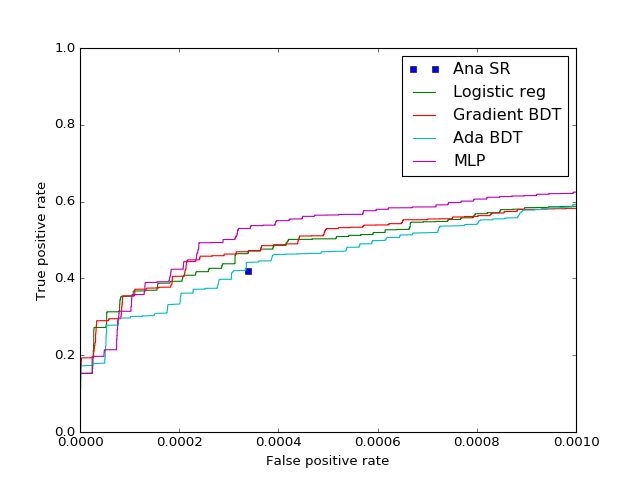

In [21]:
# Plot the ROCs
plt.figure()
plt.plot(sr_fpr, sr_tpr, 's', label='Ana SR')
for i in range(len(clfs)):
    plt.plot(clf_fprs[i], clf_tprs[i], label=clf_labels[i])
plt.xlim((0, 0.001))
plt.legend(loc=0)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

## Physics significance

Quantify performance in terms of statistical significance of the classification results

In [24]:
# Approximate median significance
def calc_ams(nsig, nbkg, reg=10):
    s = float(nsig)
    b = float(nbkg + reg)
    return np.sqrt(2 * ((s + b) * np.log(1 + s/b) - s))

In [25]:
# Calculate AMS for the SR
nsig = (w * rpv * passSR).sum()
nbkg = (w * qcd * passSR).sum()
sr_ams = calc_ams(nsig, nbkg)

In [ ]:
%%time
# Calculate the AMS for each classifier for each threshold used in the ROC
wrpv, wqcd = w*rpv, w*qcd
clf_ams = [np.zeros_like(th) for th in clf_thrs]
for i in range(len(clfs)):
    print(clf_names[i])
    for j in range(clf_thrs[i].shape[0]):
        sel = clf_probs[i] > clf_thrs[i][j]
        clf_ams[i][j] = calc_ams(wrpv.dot(sel), wqcd.dot(sel))

lr


<IPython.core.display.Javascript object>


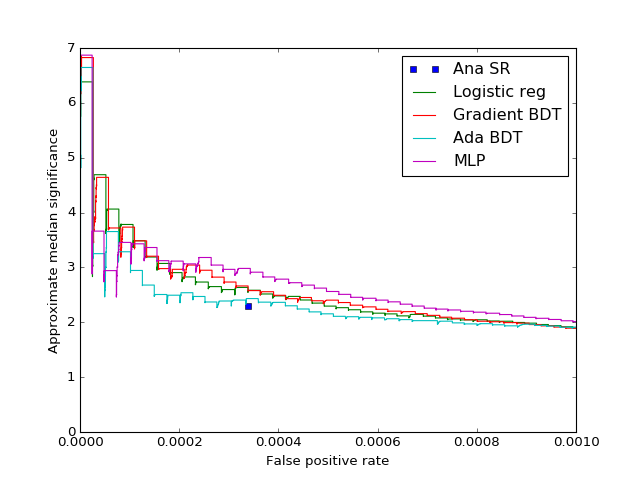

In [28]:
# Plot the AMS
plt.figure()
plt.plot(sr_fpr, sr_ams, 's', label='Ana SR')
for i in range(len(clfs)):
    plt.plot(clf_fprs[i], clf_ams[i], label=clf_labels[i])
plt.xlim((0, 0.001))
plt.legend(loc=0)
plt.xlabel('False positive rate')
plt.ylabel('Approximate median significance')

In [35]:
metrics_file = '/global/cscratch1/sd/sfarrell/atlasdl/sklearn_metrics_14p8ifb.npz'

In [36]:
np.savez(metrics_file, fpr=clf_fprs, tpr=clf_tprs, thresholds=clf_thrs,
         ams=clf_ams, names=clf_names)